# GLLBSC functional calculation
## Calculating Fundamental gap along with Band structure


In [1]:
import matplotlib.pyplot as plt
# change defaults to make plots bigger
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 dpi is really fine, but slower (i.e. for publication)

In [2]:
from ase.spacegroup import crystal
from ase.visualize import view
from ase.io import read
from ase.build import bulk
from ase.optimize import BFGS
from ase.optimize import BFGSLineSearch
from gpaw import GPAW, PW, FermiDirac
import matplotlib.pyplot as plt
from ase.dft.dos import DOS
from ase.constraints import UnitCellFilter
from ase.build import mx2
from gpaw import *
from ase.constraints import StrainFilter
from gpaw.hybrids import HybridXC
from gpaw.xc.vdw import VDWFunctional
'''
atoms=read('MoSWS.traj')
calc = GPAW(mode=PW(600),
            xc='GLLBSC',
            nbands=70,
            convergence={'bands': -20},
            setups={'Mo, W': '6'},
            occupations=FermiDirac(width=0.01),
            kpts={'size': (42, 42, 1), 'gamma': True})  
atoms.calc = calc
atoms.get_potential_energy()
calc.write('gs_gllbsc.gpw', mode='all')
'''
atoms,calc=restart('gs_gllbsc.gpw')

In [3]:
# OK, sanity checks on that calculation!
# What is the band-gap, and does it look sensible?
from ase.dft.bandgap import bandgap
gap, p1, p2 = bandgap(atoms.calc)
# Output is the gap in eV
# and from where the VBM in k-space is, and where the CBM is.
# From here you can appreciate whether the material is direct or not.

Gap: 1.396 eV
Transition (v -> c):
  (s=0, k=0, n=25, [-0.00, -0.00, 0.00]) -> (s=0, k=64, n=26, [0.33, 0.33, 0.00])


HEX(a=3.18522, c=15.1008)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



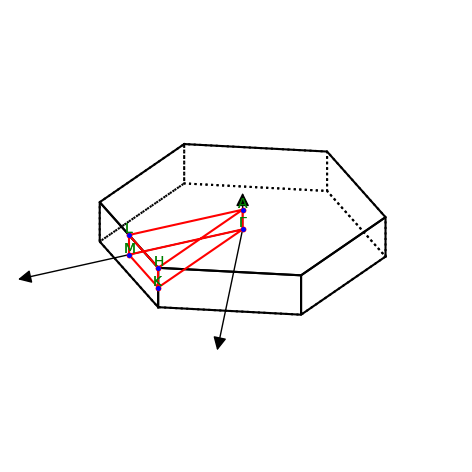

<Axes3DSubplot:>

In [4]:
# OK! Luckily ASE knows all about space groups and the reciprocal lattice.
# So let's ask it what it knows about this one, and a suggested high-symmetry path.
lat = atoms.cell.get_bravais_lattice()
print(lat.description())
lat.plot_bz(show=True)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.8.0
 |___|_|             

User:   tewodros@tewodros-HP-Pavilion-Laptop-14-bf0xx
Date:   Thu Nov 20 14:43:57 2025
Arch:   x86_64
Pid:    27337
CWD:    /home/tewodros/Desktop/Hetrostructure/HTR/revised/HTR/2H_2H/MoS2-WS2/functionals
Python: 3.7.12
gpaw:   /home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/tewodros/miniconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/tewodros/miniconda3/lib/python3.7/site-packages/ase (version 3.22.1)
numpy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/numpy (version 1.21.6)
scipy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/scipy (version 1.7.3)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: True
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: -20,
                density: 0.0001,
                eigenstates: 4e-08,
                energy: 0.0005}
  gpts

     iter     time        total  log10-change:
                         energy  eigst   dens
iter:   1 14:45:55   -45.902811  +2.15       c
iter:   2 14:46:56   -45.945556  +0.70       c
iter:   3 14:47:57   -45.946913  -0.38       c
iter:   4 14:48:58   -45.947006c -1.43       c
iter:   5 14:50:08   -45.947014c -2.41       c
iter:   6 14:51:17   -45.947015c -3.30       c
iter:   7 14:52:28   -45.947015c -4.18       c
iter:   8 14:53:42   -45.947015c -5.14       c
iter:   9 14:54:55   -45.947015c -6.12       c
iter:  10 14:56:06   -45.947015c -7.13       c
iter:  11 14:57:25   -45.947015c -8.16c      c

Converged after 11 iterations.

Dipole moment: (-0.641241, 0.370221, -0.002832) |e|*Ang

Energy contributions relative to reference atoms: (reference = -592077.734005)

Kinetic:        +80.514429
Potential:      -85.439350
External:        +0.000000
XC:             -41.491970
Entropy (-ST):   -0.000000
Local:           +0.469876
--------------------------
Free energy:    -45.947015
Extr

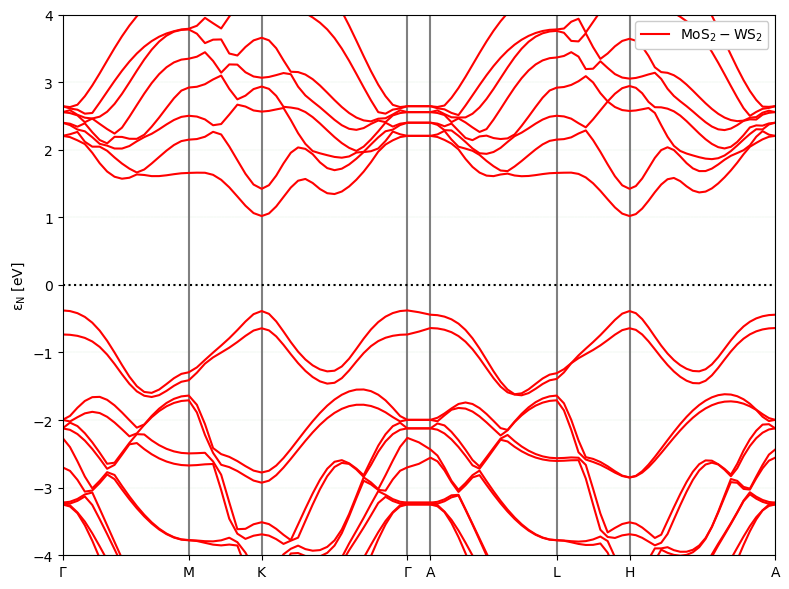

In [5]:
bs_calc = calc.fixed_density(kpts={'path': 'GMKGALHA', 'npoints': 100}, symmetry='off')
 # path through k-space taken from Materials project; or from analysis above

bs_calc.get_potential_energy() # eval at these k-point path
bs = bs_calc.band_structure().subtract_reference()
#bs=bs_calc.band_structure() # generate the plot object
#bs.ylabel(r'$\varepsilon_N(k)$ [eV]', size=24)
bs.plot(ylabel=r'$\mathrm{\varepsilon_N}$ [eV]', label=r'$\mathrm{MoS_{2}-WS_{2}}$', loc="upper right", color='r', emax=4, emin=-4)
plt.grid(which='major', axis='both', zorder=-1.0, color = 'green', linestyle = '--', linewidth = 0.05)
plt.tight_layout()
#plt.savefig('MoS2-MoS2.eps')
plt.show()

In [6]:
# Get the accurate HOMO and LUMO from the band structure calculator
homo, lumo = bs_calc.get_homo_lumo()

# Calculate the discontinuity potential using the ground state calculator and
# the accurate HOMO and LUMO
response = calc.hamiltonian.xc.response
dxc_pot = response.calculate_discontinuity_potential(homo, lumo)

# Calculate the discontinuity using the band structure calculator
bs_response = bs_calc.hamiltonian.xc.response
KS_gap, dxc = bs_response.calculate_discontinuity(dxc_pot)

In [7]:
# Derivative discontinuity
dxc

0.49787953694975645

In [8]:
KS_gap

1.3961350749646055

In [9]:
# Fundamental band gap = Kohn-Sham band gap + derivative discontinuity
QP_gap = KS_gap + dxc
QP_gap

1.894014611914362